# SAX Paper Replication By Rezkellah Fatma-Zohra Supervised by Mr.Paul Boniol

In [3]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
import requests
from io import StringIO
from pyts.datasets import make_cylinder_bell_funnel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from collections import defaultdict
from itertools import combinations

### 1. SAX Method Implementation & Testing

In [4]:
class SAX:
    def __init__(self, word_size, alphabet_size, original_length):
        """
        word_size: number of PAA segments (w)
        alphabet_size: number of symbols (a)
        original_length: original time series length (n)
        """
        self.word_size = word_size
        self.alphabet_size = alphabet_size
        self.original_length = original_length
        self.breakpoints = self._generate_breakpoints(alphabet_size)
        self.dist_lookup = self._precompute_distances()

    def _generate_breakpoints(self, alphabet_size):
        # Generate breakpoints that split a Gaussian distribution into equal areas.
        return norm.ppf(np.linspace(0, 1, alphabet_size + 1)[1:-1])

    def _precompute_distances(self):
        dist_matrix = np.zeros((self.alphabet_size, self.alphabet_size))
        for i in range(self.alphabet_size):
            for j in range(i + 1, self.alphabet_size):
                dist_matrix[i, j] = (self.breakpoints[j - 1] - self.breakpoints[i]) ** 2
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    def normalize(self, series, epsilon=1e-6):
        mean = np.mean(series)
        std = np.std(series)
        if std < epsilon:
            return np.zeros_like(series)
        return (series - mean) / std

    def paa(self, series):
        n = len(series)
        step = n / self.word_size
        paa_rep = np.array([np.mean(series[int(i * step): int((i + 1) * step)]) for i in range(self.word_size)])
        return paa_rep

    def to_sax(self, series):
        # Normalize, then apply PAA, and finally discretize into symbols (as integer codes).
        norm_series = self.normalize(series)
        paa_rep = self.paa(norm_series)
        sax_symbols = np.digitize(paa_rep, self.breakpoints)
        sax_str = ''.join(chr(97+s) for s in sax_symbols)
        return sax_str

    def mindist(self, sax1, sax2):
        # MINDIST: sqrt((n/w) * sum_i (dist(sax1_i, sax2_i))^2)
        squared_sum = 0
        for i in range(self.word_size):
            idx1 = ord(sax1[i]) - ord('a')
            idx2 = ord(sax2[i]) - ord('a')
            squared_sum += self.dist_lookup[idx1, idx2]
        return np.sqrt((self.original_length / self.word_size) * squared_sum)

In [ ]:
# Example sinusoidal signal
sax = SAX(word_size=8, alphabet_size=5, original_length=7)
time_series = np.sin(np.linspace(0, 2 * np.pi, 100))
sax_representation = sax.to_sax(time_series)
print(f"SAX Representation: {sax_representation}")

SAX Representation: deedbaab


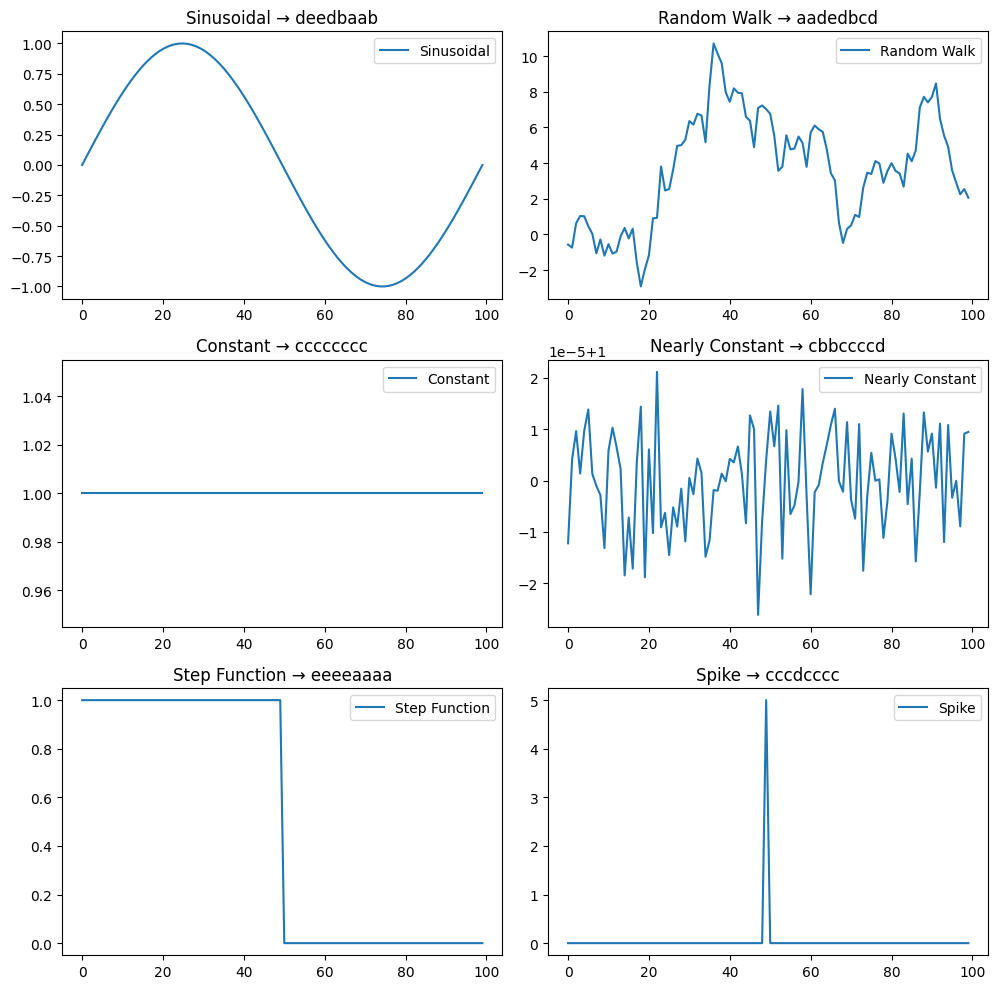

In [ ]:
# A bit of testing
import matplotlib.pyplot as plt

test_cases = {
    "Sinusoidal": np.sin(np.linspace(0, 2 * np.pi, 100)),
    "Random Walk": np.cumsum(np.random.randn(100)),
    "Constant": np.ones(100),
    "Nearly Constant": np.ones(100) + np.random.normal(0, 1e-5, 100),
    "Step Function": np.concatenate([np.ones(50), np.zeros(50)]),
    "Spike": np.concatenate([np.zeros(49), [5], np.zeros(50)]),
}

sax = SAX(word_size=8, alphabet_size=5, original_length=7)

plt.figure(figsize=(10, 10))
for i, (name, ts) in enumerate(test_cases.items()):
    sax_representation = sax.to_sax(ts)

    plt.subplot(3, 2, i + 1)
    plt.plot(ts, label=name)
    plt.title(f"{name} → {sax_representation}")
    plt.legend()

plt.tight_layout()
plt.show()

### 2. SDA Implementation

In [ ]:
class SDA:
    def __init__(self, alphabet_size):
        self.alphabet_size = alphabet_size

    def to_sda(self, ts):
        diffs = np.diff(ts)
        # Determine breakpoints using percentiles.
        breakpoints = np.percentile(diffs, np.linspace(0, 100, self.alphabet_size + 1)[1:-1])
        sda_symbols = ""
        for d in diffs:
            idx = np.sum(d > breakpoints)
            sda_symbols += chr(97 + idx)
        return sda_symbols

### 3. IMPACTS

In [ ]:
class IMPACTS:
    def __init__(self, alphabet_size):
        self.alphabet_size = alphabet_size

    def to_impacts(self, ts):
        # Compute change ratios.
        ratios = []
        for i in range(len(ts) - 1):
            if abs(ts[i]) < 1e-6:
                r = 0
            else:
                r = (ts[i+1] - ts[i]) / ts[i]
            ratios.append(r)
        ratios = np.array(ratios)

        breakpoints = np.percentile(ratios, np.linspace(0, 100, self.alphabet_size + 1)[1:-1])
        impacts_symbols = ""
        for r in ratios:
            idx = np.sum(r > breakpoints)
            impacts_symbols += chr(97 + idx)
        return impacts_symbols

In [ ]:
def symbolic_distance(sym_str1, sym_str2):
    vec1 = np.array([ord(ch) - ord('a') for ch in sym_str1])
    vec2 = np.array([ord(ch) - ord('a') for ch in sym_str2])
    return np.linalg.norm(vec1 - vec2)

### 2. Papers Experiements Reproducibility

#### 1. Hierarchical Clustering

In [ ]:
def load_control_chart():
    # Fetch the Synthetic Control Chart dataset from UCI.
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/synthetic_control-mld/synthetic_control.data'
    response = requests.get(url)
    data = np.loadtxt(StringIO(response.text))
    return data

In [ ]:
load_control_chart()

array([[28.7812, 34.4632, 31.3381, ..., 33.3759, 25.4652, 25.8717],
       [24.8923, 25.741 , 27.5532, ..., 34.2484, 32.1005, 26.691 ],
       [31.3987, 30.6316, 26.3983, ..., 33.9002, 29.5446, 29.343 ],
       ...,
       [35.899 , 26.6719, 34.1911, ..., 15.9268, 18.0843, 17.4747],
       [24.5383, 24.2802, 28.2814, ..., 19.3096, 12.9985, 17.4599],
       [34.3354, 30.9375, 31.9529, ..., 11.7426, 11.6989, 10.1521]])

In [ ]:
# Load dataset and extract 9 samples:
# Order: 0-99: Normal, 100-199: Cyclic, 200-299: Increasing trend,
# 300-399: Decreasing trend, 400-499: Upward shift, 500-599: Downward shift.
data_control = load_control_chart()
samples_per_class = 3
decreasing = data_control[300:300+samples_per_class]
upward = data_control[400:400+samples_per_class]
normal = data_control[0:samples_per_class]
control_samples = np.vstack((decreasing, upward, normal))
control_labels = (['Decreasing Trend'] * samples_per_class +
                  ['Upward Shift'] * samples_per_class +
                  ['Normal'] * samples_per_class)

In [ ]:
# Euclidean distance matrix on raw data:
euclid_dist = squareform(pdist(control_samples, metric='euclidean'))

In [ ]:
# SAX distance matrix
n_control = control_samples.shape[1]
word_size = 8
alphabet_size = 8  # as in the paper (alphabet=8)
sax_control = SAX(word_size, alphabet_size, n_control)
sax_reps = [sax_control.to_sax(sample) for sample in control_samples]
sax_dist = np.zeros((len(sax_reps), len(sax_reps)))
for i in range(len(sax_reps)):
    for j in range(i+1, len(sax_reps)):
        d = sax_control.mindist(sax_reps[i], sax_reps[j])
        sax_dist[i, j] = d
        sax_dist[j, i] = d

In [ ]:
# SDA distance matrix
sda_obj = SDA(alphabet_size)
sda_reps = [sda_obj.to_sda(ts) for ts in control_samples]
sda_dist = np.zeros((len(sda_reps), len(sda_reps)))
for i in range(len(sda_reps)):
    for j in range(i+1, len(sda_reps)):
        d = symbolic_distance(sda_reps[i], sda_reps[j])
        sda_dist[i, j] = d
        sda_dist[j, i] = d

In [ ]:
# IMPACTS distance matrix
impacts_obj = IMPACTS(alphabet_size=8)
impacts_reps = [impacts_obj.to_impacts(ts) for ts in control_samples]
impacts_dist = np.zeros((len(impacts_reps), len(impacts_reps)))
for i in range(len(impacts_reps)):
    for j in range(i+1, len(impacts_reps)):
        d = symbolic_distance(impacts_reps[i], impacts_reps[j])
        impacts_dist[i, j] = d
        impacts_dist[j, i] = d

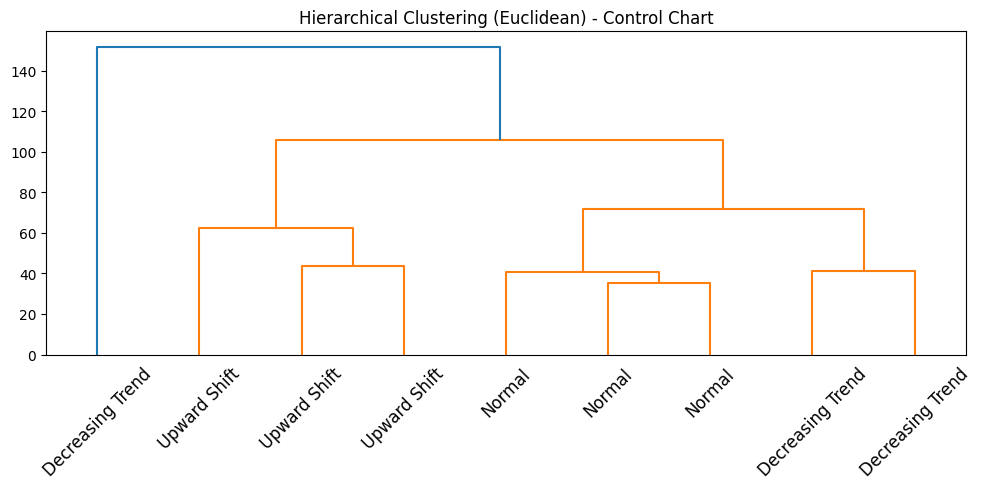

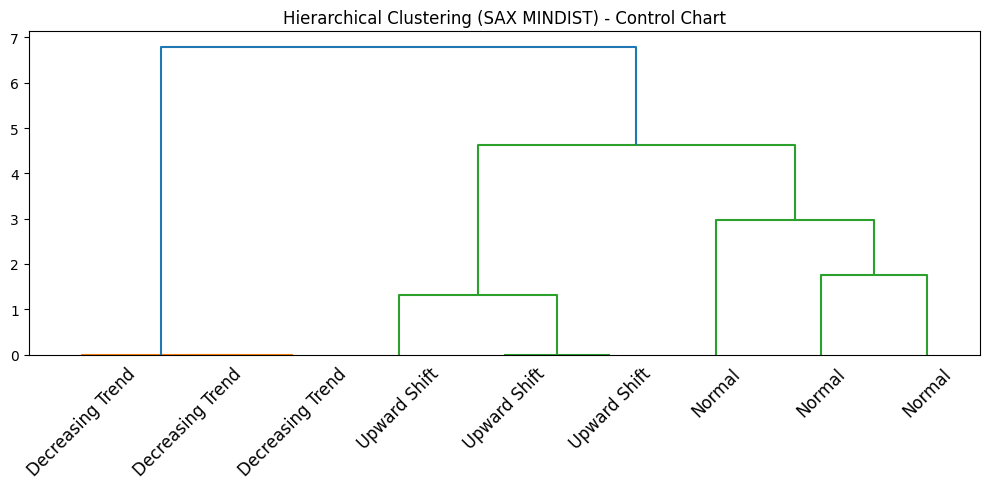

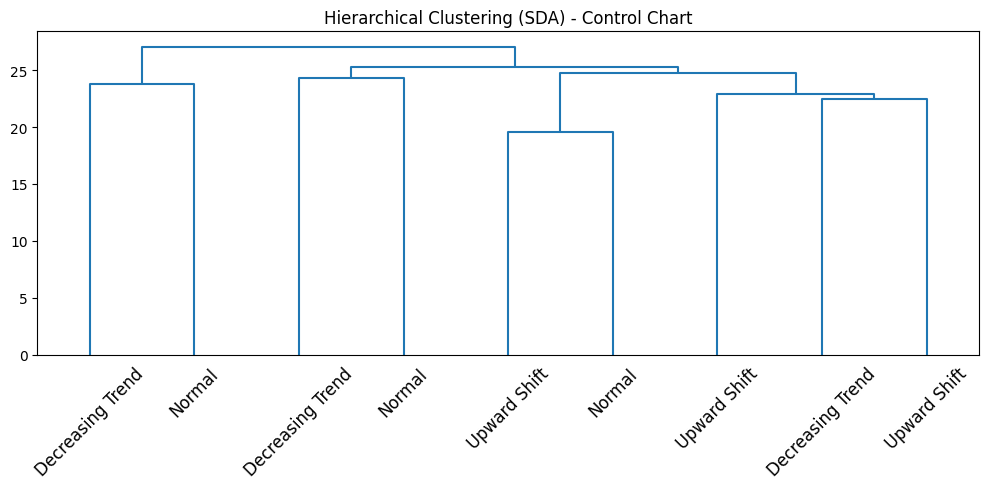

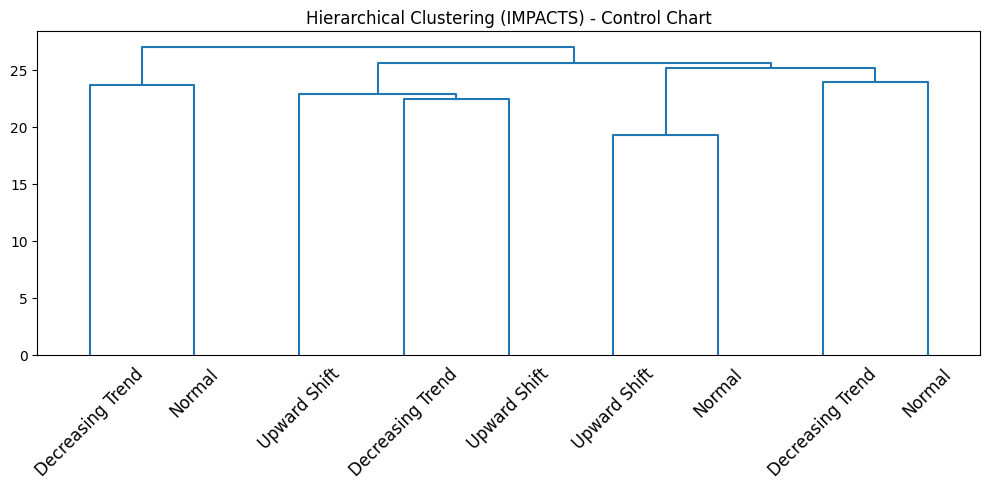

In [ ]:
# Plot dendrograms:
def plot_dendrogram(dist_matrix, labels, title, orientation='top'):
    Z = linkage(squareform(dist_matrix), method='average')
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=labels, orientation=orientation, leaf_rotation=45, leaf_font_size=12)
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_dendrogram(euclid_dist, control_labels, 'Hierarchical Clustering (Euclidean) - Control Chart')
plot_dendrogram(sax_dist, control_labels, 'Hierarchical Clustering (SAX MINDIST) - Control Chart')
plot_dendrogram(sda_dist, control_labels, 'Hierarchical Clustering (SDA) - Control Chart')
plot_dendrogram(impacts_dist, control_labels, 'Hierarchical Clustering (IMPACTS) - Control Chart')

#### 2. K-means

In [ ]:
def load_space_shuttle_data():
    # Simulate Space Shuttle telemetry data:
    np.random.seed(42)
    num_series = 1000
    length = 512
    t = np.linspace(0, 4*np.pi, length)
    data = []
    for _ in range(num_series):
        phase = np.random.uniform(0, 2*np.pi)
        freq = np.random.uniform(0.8, 1.2)
        ts = np.sin(freq * t + phase) + 0.2 * np.random.randn(length)
        data.append(ts)
    return np.array(data)

telemetry_data = load_space_shuttle_data()

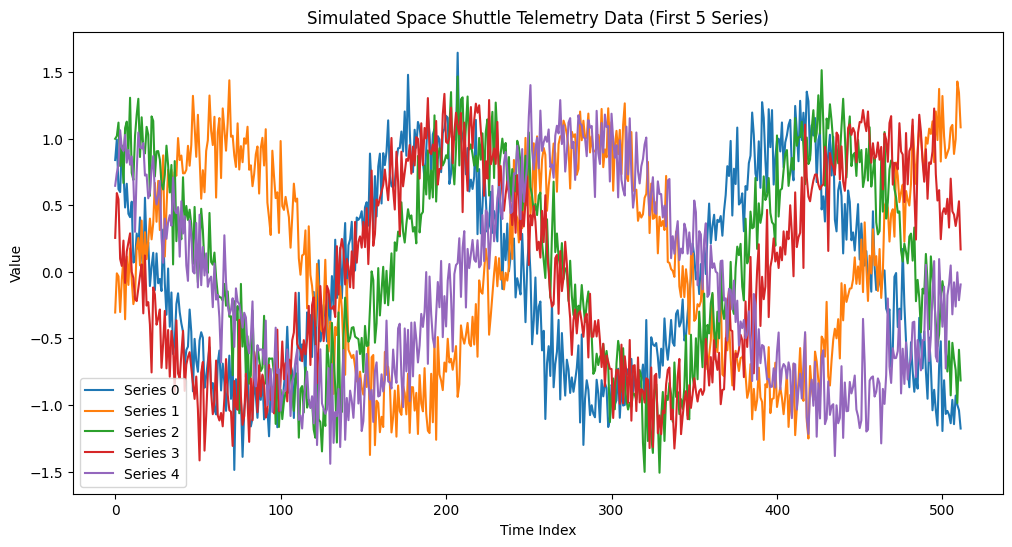

In [ ]:
# Plot the first 5 time series.
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(telemetry_data[i], label=f"Series {i}")
plt.title("Simulated Space Shuttle Telemetry Data (First 5 Series)")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
# K-Means on RAW data
k_raw = 4
max_iters = 11  # Number of iterations

inertia_raw = []
kmeans_raw = KMeans(n_clusters=k_raw, init="random", n_init=1, max_iter=1, random_state=42)

for _ in range(max_iters):
    kmeans_raw.fit(telemetry_data)
    inertia_raw.append(kmeans_raw.inertia_)

labels_raw = kmeans_raw.labels_
silhouette_raw = silhouette_score(telemetry_data, labels_raw)
print("K-Means (Raw Data) Silhouette Score:", silhouette_raw)

K-Means (Raw Data) Silhouette Score: 0.28632794304767817


In [9]:
# Map SAX string to numeric vector: 'a' -> 0, 'b' -> 1, etc.
def str_to_numeric(sax_str):
    return np.array([ord(ch) - ord('a') for ch in sax_str])


In [ ]:
# K-Means on SAX data
sax_telemetry = SAX(word_size=16, alphabet_size=8, original_length=512)
sax_reps_telemetry = [sax_telemetry.to_sax(ts) for ts in telemetry_data]

sax_features = np.array([str_to_numeric(s) for s in sax_reps_telemetry])

inertia_sax = []
kmeans_sax = KMeans(n_clusters=k_raw, init="random", n_init=1, max_iter=1, random_state=42)

for _ in range(max_iters):
    kmeans_sax.fit(sax_features)
    inertia_sax.append(kmeans_sax.inertia_)

labels_sax = kmeans_sax.labels_
silhouette_sax = silhouette_score(sax_features, labels_sax)
print("K-Means (SAX) Silhouette Score:", silhouette_sax)

K-Means (SAX) Silhouette Score: 0.3328240733746735


In [ ]:
# K-Means on SDA data
sda_instance = SDA(alphabet_size=8)
sda_reps = [sda_instance.to_sda(ts) for ts in telemetry_data]
sda_features = np.array([str_to_numeric(s) for s in sda_reps])
kmeans_sda = KMeans(n_clusters=k_raw, random_state=42)
labels_sda = kmeans_sda.fit_predict(sda_features)
silhouette_sda = silhouette_score(sda_features, labels_sda)
print("K-Means (SDA) Silhouette Score:", silhouette_sda)

K-Means (SDA) Silhouette Score: 0.0030810577625237606


In [ ]:
# K-Means on IMPACTS data
impacts_instance = IMPACTS(alphabet_size=8)
impacts_reps = [impacts_instance.to_impacts(ts) for ts in telemetry_data]
impacts_features = np.array([str_to_numeric(s) for s in impacts_reps])
kmeans_impacts = KMeans(n_clusters=k_raw, random_state=42)
labels_impacts = kmeans_impacts.fit_predict(impacts_features)
silhouette_impacts = silhouette_score(impacts_features, labels_impacts)
print("K-Means (IMPACTS) Silhouette Score:", silhouette_impacts)

K-Means (IMPACTS) Silhouette Score: 0.006537282130301692


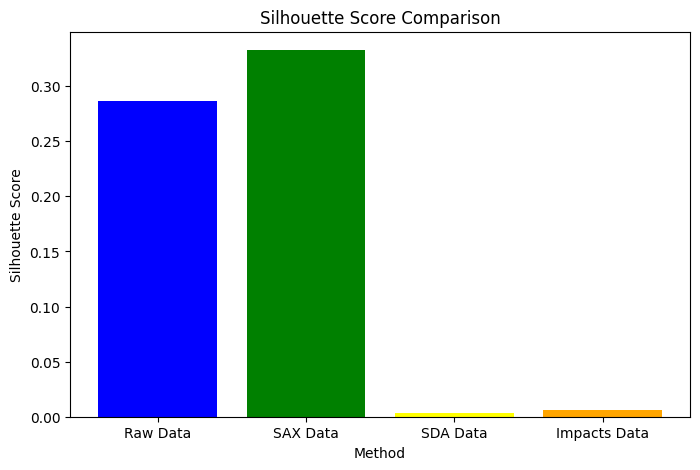

In [ ]:
# --- Plot Silhouette Score ---
plt.figure(figsize=(8, 5))
plt.bar(['Raw Data', 'SAX Data', 'SDA Data', 'Impacts Data'], [silhouette_raw, silhouette_sax, silhouette_sda, silhouette_impacts], color=['blue', 'green', 'yellow', 'orange'])
plt.xlabel("Method")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Comparison")
plt.show()

#### 3. 1-NN Classification (Leave-One-Out) on CBF Dataset

In [5]:
# 1. Load the CBF dataset
X, y = make_cylinder_bell_funnel(n_samples=150, random_state=42)

X_train_cbf, X_test_cbf, y_train_cbf, y_test_cbf = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

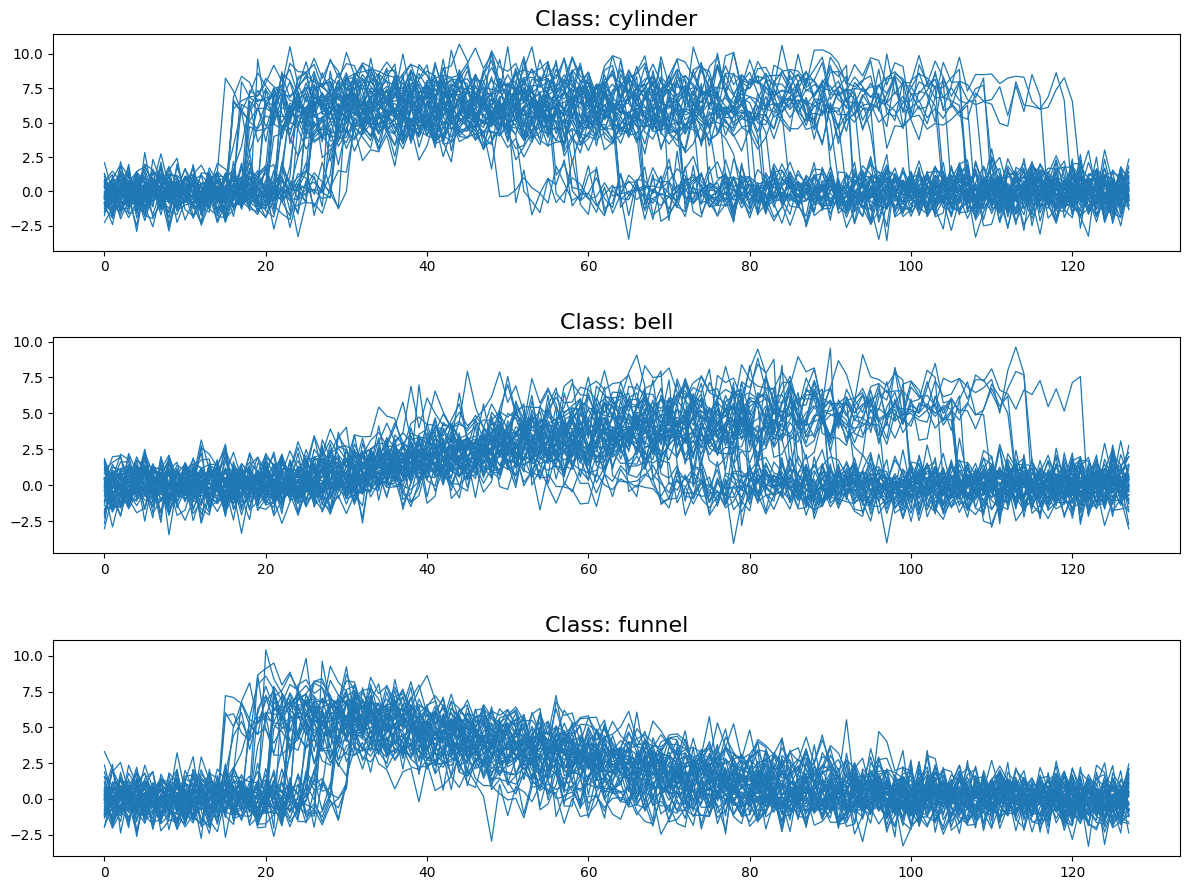

In [ ]:
plt.figure(figsize=(12, 9))
for i, classe in enumerate(['cylinder', 'bell', 'funnel']):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [11]:
# Normalize the data (Z-normalization)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_cbf)
X_test_norm = scaler.transform(X_test_cbf)

# 1-NN Classifier on Raw Data (Euclidean Distance)
knn_raw = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn_raw.fit(X_train_norm, y_train_cbf)
y_pred_raw = knn_raw.predict(X_test_norm)
accuracy_raw = accuracy_score(y_test_cbf, y_pred_raw)
error_raw = 1 - accuracy_raw
print(f'1-NN Error Rate on Raw Data: {error_raw * 100:.2f}%')

1-NN Error Rate on Raw Data: 6.67%


In [ ]:
def to_lp(ts, word_size=16):
    n = len(ts)
    segment_size = n // word_size
    paa = np.array([np.mean(ts[i*segment_size:(i+1)*segment_size]) for i in range(word_size)])
    return paa

def lp_inf_distance(paa1, paa2, word_size=16, original_length=128):
    # LP∞: scaled maximum absolute difference
    return np.sqrt((original_length / word_size)) * np.max(np.abs(paa1 - paa2))

lp_train = [to_lp(ts, word_size=16) for ts in X_train_norm]
pred_lp = []
loo = LeaveOneOut()
for train_idx, test_idx in loo.split(lp_train):
    test_rep = lp_train[test_idx[0]]
    train_reps = [lp_train[i] for i in train_idx]
    dists = [lp_inf_distance(test_rep, rep, word_size=16, original_length=128) for rep in train_reps]
    nn = np.argmin(dists)
    pred_lp.append(y_train_cbf[train_idx][nn])
pred_lp = np.array(pred_lp)
acc_lp = accuracy_score(y_train_cbf, pred_lp)
error_lp = 1 - acc_lp
print(f"LP (PAA, L∞) 1-NN Error Rate: {error_lp*100:.2f}%")


LP (PAA, L∞) 1-NN Error Rate: 10.48%


In [ ]:
# SDA 1-NN Classification (Fixed Alphabet Size = 5)
sda_converter = SDA(alphabet_size=5)
sda_train = [sda_converter.to_sda(ts) for ts in X_train_norm]
sda_test = [sda_converter.to_sda(ts) for ts in X_test_norm]

y_pred_sda = []
for test_sym in sda_test:
    min_dist = float('inf')
    best_label = None
    test_vec = str_to_numeric(test_sym)
    for i, train_sym in enumerate(sda_train):
        train_vec = str_to_numeric(train_sym)
        dist = np.linalg.norm(test_vec - train_vec)
        if dist < min_dist:
            min_dist = dist
            best_label = y_train_cbf[i]
    y_pred_sda.append(best_label)

accuracy_sda = accuracy_score(y_test_cbf, y_pred_sda)
error_sda = 1 - accuracy_sda
print(f'1-NN Error on SDA Data (Alphabet Size 5): {error_sda * 100:.2f}%')

1-NN Error on SDA Data (Alphabet Size 5): 64.44%


In [ ]:
def one_nn_classification_symbolic(X, y, transform_func, distance_func):
    loo = LeaveOneOut()
    X_sym = [transform_func(ts) for ts in X]
    predictions = []
    for train_idx, test_idx in loo.split(X_sym):
        test_rep = X_sym[test_idx[0]]
        train_reps = [X_sym[i] for i in train_idx]
        dists = [distance_func(test_rep, rep) for rep in train_reps]
        nn = np.argmin(dists)
        predictions.append(y[train_idx][nn])
    return np.array(predictions)

In [ ]:
# For SAX and IMPACTS, we vary the alphabet size.
alphabet_sizes = range(3, 11)
error_sax = []
error_impacts = []

for alph in alphabet_sizes:
    # SAX
    sax_obj = SAX(word_size=16, alphabet_size=alph, original_length=128)
    pred = one_nn_classification_symbolic(
        X_train_norm, y_train_cbf,
        transform_func=sax_obj.to_sax,
        distance_func=lambda s1, s2: sax_obj.mindist(s1, s2)
    )
    acc = accuracy_score(y_train_cbf, pred)
    error_sax.append(1 - acc)
    print(f"SAX 1-NN Error Rate (Alphabet {alph}): {(1-acc)*100:.2f}%")

    # IMPACTS
    impacts_obj = IMPACTS(alphabet_size=alph)
    pred = one_nn_classification_symbolic(
        X_train_norm, y_train_cbf,
        transform_func=impacts_obj.to_impacts,
        distance_func=lambda s1, s2: np.linalg.norm(str_to_numeric(s1) - str_to_numeric(s2))
    )
    acc = accuracy_score(y_train_cbf, pred)
    error_impacts.append(1 - acc)
    print(f"IMPACTS 1-NN Error Rate (Alphabet {alph}): {(1-acc)*100:.2f}%")

SAX 1-NN Error Rate (Alphabet 3): 39.05%
IMPACTS 1-NN Error Rate (Alphabet 3): 58.10%
SAX 1-NN Error Rate (Alphabet 4): 18.10%
IMPACTS 1-NN Error Rate (Alphabet 4): 52.38%
SAX 1-NN Error Rate (Alphabet 5): 6.67%
IMPACTS 1-NN Error Rate (Alphabet 5): 52.38%
SAX 1-NN Error Rate (Alphabet 6): 11.43%
IMPACTS 1-NN Error Rate (Alphabet 6): 56.19%
SAX 1-NN Error Rate (Alphabet 7): 7.62%
IMPACTS 1-NN Error Rate (Alphabet 7): 58.10%
SAX 1-NN Error Rate (Alphabet 8): 5.71%
IMPACTS 1-NN Error Rate (Alphabet 8): 55.24%
SAX 1-NN Error Rate (Alphabet 9): 8.57%
IMPACTS 1-NN Error Rate (Alphabet 9): 57.14%
SAX 1-NN Error Rate (Alphabet 10): 6.67%
IMPACTS 1-NN Error Rate (Alphabet 10): 57.14%


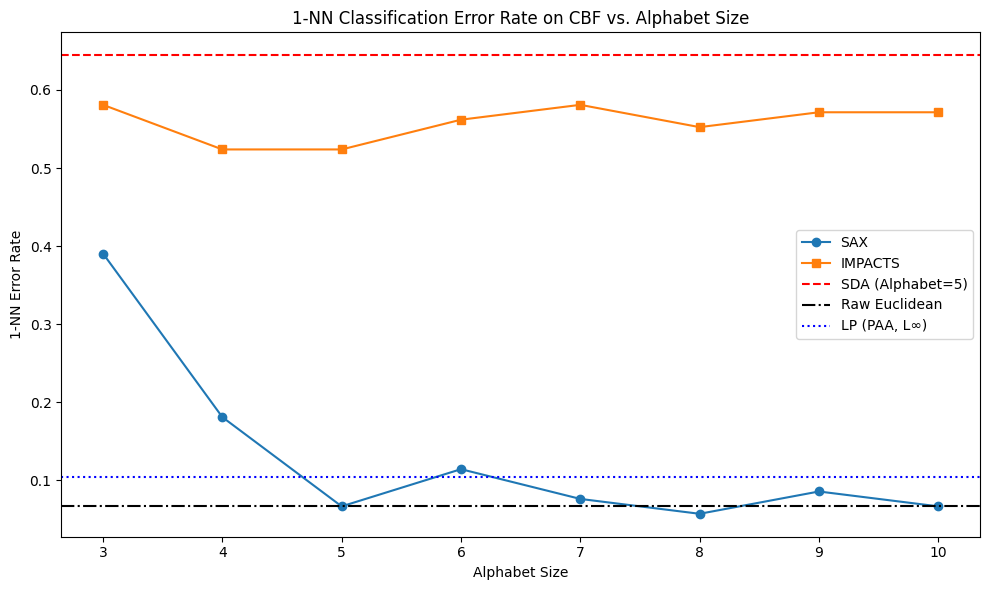

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(list(alphabet_sizes), error_sax, marker='o', label='SAX')
plt.plot(list(alphabet_sizes), error_impacts, marker='s', label='IMPACTS')
plt.axhline(y=error_sda, color='r', linestyle='--', label='SDA (Alphabet=5)')
plt.axhline(y=error_raw, color='k', linestyle='-.', label='Raw Euclidean')
plt.axhline(y=error_lp, color='b', linestyle=':', label='LP (PAA, L∞)')
plt.xlabel("Alphabet Size")
plt.ylabel("1-NN Error Rate")
plt.title("1-NN Classification Error Rate on CBF vs. Alphabet Size")
plt.legend()
plt.tight_layout()
plt.show()


#### 4. Decision Tree

In [6]:
# Build the RT representation over the Raw data
def regression_tree_representation(X, n_segments=10):
    X_rt = []
    for series in X:
        segment_length = len(series) // n_segments
        segments = [np.mean(series[i * segment_length:(i + 1) * segment_length]) for i in range(n_segments)]
        X_rt.append(segments)
    return np.array(X_rt)

In [13]:
# 2. Decision Tree on Raw Data
X_rt= regression_tree_representation(X)
X_rt_train, X_rt_test, y_train, y_test = train_test_split(X_rt, y, test_size=0.2, random_state=42)
dt_rt = DecisionTreeClassifier(random_state=42)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_rt_train)
X_test_norm = scaler.transform(X_rt_test)
dt_rt.fit(X_rt_train, y_train)
y_rt_pred = dt_rt.predict(X_rt_test)
accuracy_rt = accuracy_score(y_test, y_rt_pred)

print(f"Accuracy using Regression Tree Representation: {accuracy_rt*100:.4f}%")

Accuracy using Regression Tree Representation: 86.6667%


In [12]:
# Decision Tree on SAX Data
sax_converter = SAX(word_size=8, alphabet_size=6, original_length=128)
sax_train = [sax_converter.to_sax(ts) for ts in X_train_norm]
sax_test = [sax_converter.to_sax(ts) for ts in X_test_norm]

sax_train_num = np.array([str_to_numeric(s) for s in sax_train])
sax_test_num = np.array([str_to_numeric(s) for s in sax_test])


dtree = DecisionTreeClassifier()
dtree.fit(sax_train_num, y_train_cbf)
y_pred_sax = dtree.predict(sax_test_num)
acc_sax = accuracy_score(y_test_cbf, y_pred_sax)
print(f"Decision Tree Accuracy on SAX Data (CBF): {acc_sax * 100:.2f}%")

Decision Tree Accuracy on SAX Data (CBF): 84.44%


#### 4. Anomaly Detection

In [ ]:
# Generate normal sine wave (training data)
def generate_sine_wave(length=1000, noise_level=0.05):
    np.random.seed(42)
    t = np.linspace(0, 4 * np.pi, length)
    sine_wave = np.sin(t) + noise_level * np.random.randn(length)
    return sine_wave

# Generate test data with anomalies at 250, 500, 750
def generate_test_data():
    data = generate_sine_wave()
    anomalies = [(250, 2), (500, -2), (750, 1.5)]
    for idx, magnitude in anomalies:
        data[idx:idx+10] += magnitude
    return data, [idx for idx, _ in anomalies]

In [ ]:
# Build a Markov Model from symbolic sequence
def build_markov_model(symbols, order=2):
    model = defaultdict(lambda: defaultdict(int))
    for i in range(len(symbols) - order):
        context = tuple(symbols[i:i+order])
        next_symbol = symbols[i+order]
        model[context][next_symbol] += 1


    for context in model:
        total = sum(model[context].values())
        for symbol in model[context]:
            model[context][symbol] /= total
    return model

In [ ]:
# Detect anomalies using Markov Model
def detect_anomalies(symbols, model, threshold=0.1, order=2):
    anomaly_scores = np.zeros(len(symbols))
    for i in range(len(symbols) - order):
        context = tuple(symbols[i:i+order])
        next_symbol = symbols[i+order]
        prob = model.get(context, {}).get(next_symbol, 0)

        # If probability is very low, flag as anomaly
        if prob < threshold:
            anomaly_scores[i+order] = 1
    return anomaly_scores


In [ ]:
train_data = generate_sine_wave()
test_data, anomaly_positions = generate_test_data()

# Convert data using SAX, SDA, IMPACTS
sax_converter = SAX(word_size=12, alphabet_size=4, original_length=1000)
sax_train = sax_converter.to_sax(train_data)
sax_test = sax_converter.to_sax(test_data)

sda_converter = SDA(alphabet_size=6)
sda_train = sda_converter.to_sda(train_data)
sda_test = sda_converter.to_sda(test_data)

impacts_converter = IMPACTS(alphabet_size=6)
impacts_train = impacts_converter.to_impacts(train_data)
impacts_test = impacts_converter.to_impacts(test_data)

# Build Markov Models
sax_markov = build_markov_model(sax_train)
sda_markov = build_markov_model(sda_train)
impacts_markov = build_markov_model(impacts_train)

# Detect anomalies
sax_anomalies = detect_anomalies(sax_test, sax_markov)
sda_anomalies = detect_anomalies(sda_test, sda_markov)
impacts_anomalies = detect_anomalies(impacts_test, impacts_markov)

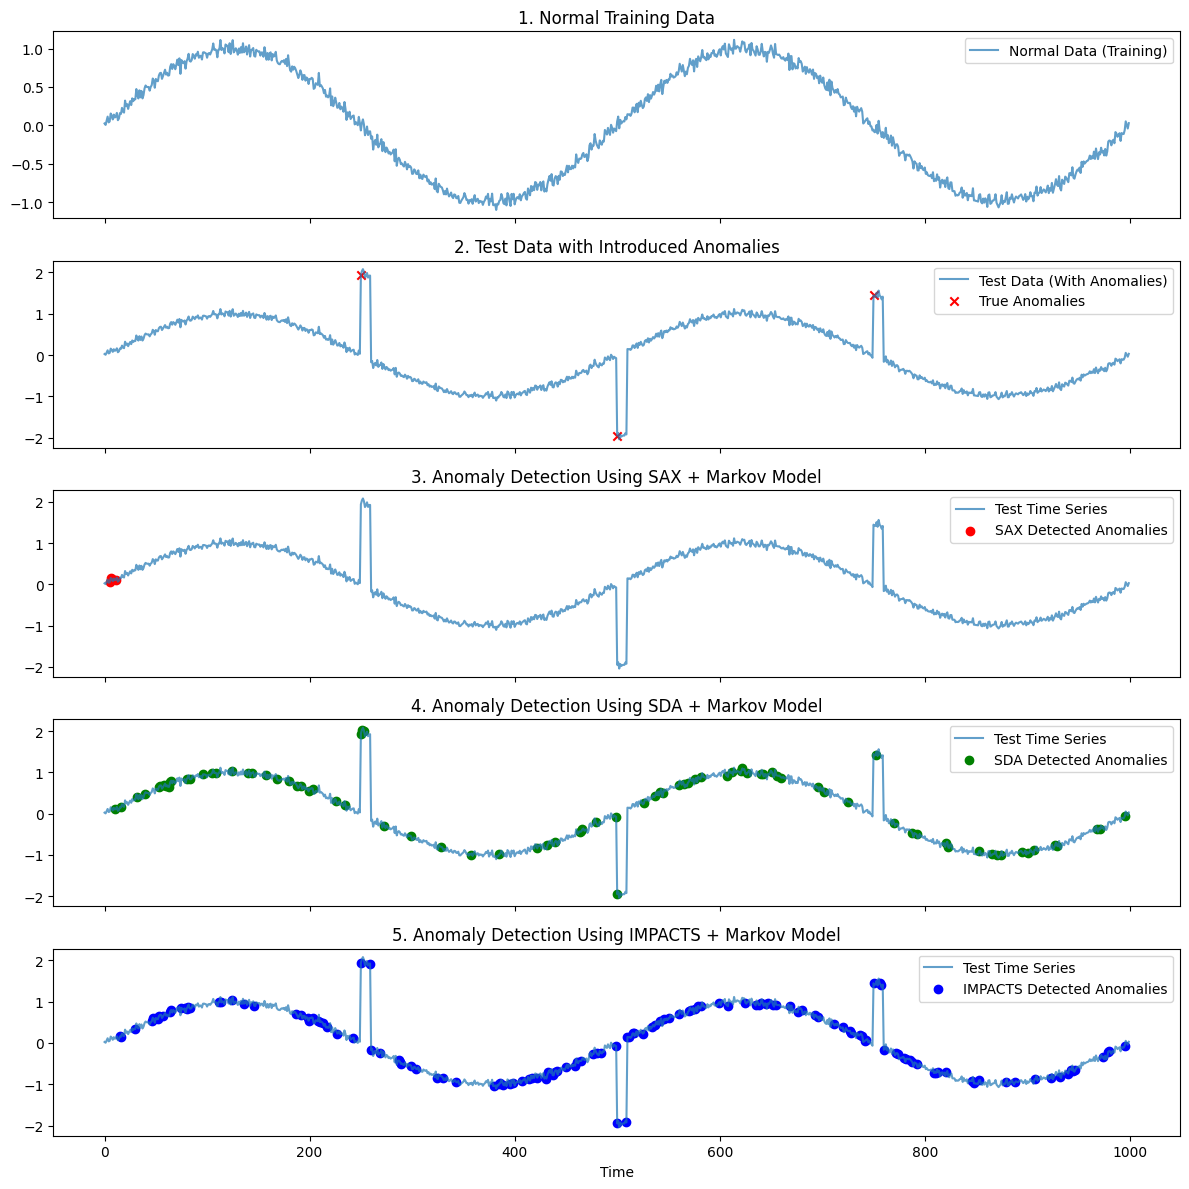

In [ ]:
# Visualization
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

# 1. Training Data (Normal)
axes[0].plot(train_data, label="Normal Data (Training)", alpha=0.7)
axes[0].set_title("1. Normal Training Data")
axes[0].legend()

# 2. Test Data with Anomalies
axes[1].plot(test_data, label="Test Data (With Anomalies)", alpha=0.7)
axes[1].scatter(anomaly_positions, test_data[anomaly_positions], color='red', label="True Anomalies", marker='x')
axes[1].set_title("2. Test Data with Introduced Anomalies")
axes[1].legend()

# 3. SAX + Markov Model Anomalies
axes[2].plot(test_data, label="Test Time Series", alpha=0.7)
axes[2].scatter(np.where(sax_anomalies > 0), test_data[np.where(sax_anomalies > 0)], color='r', label="SAX Detected Anomalies", marker='o')
axes[2].set_title("3. Anomaly Detection Using SAX + Markov Model")
axes[2].legend()

# 4. SDA + Markov Model Anomalies
axes[3].plot(test_data, label="Test Time Series", alpha=0.7)
axes[3].scatter(np.where(sda_anomalies > 0), test_data[np.where(sda_anomalies > 0)], color='g', label="SDA Detected Anomalies", marker='o')
axes[3].set_title("4. Anomaly Detection Using SDA + Markov Model")
axes[3].legend()

# 5. IMPACTS + Markov Model Anomalies
axes[4].plot(test_data, label="Test Time Series", alpha=0.7)
axes[4].scatter(np.where(impacts_anomalies > 0), test_data[np.where(impacts_anomalies > 0)], color='b', label="IMPACTS Detected Anomalies", marker='o')
axes[4].set_title("5. Anomaly Detection Using IMPACTS + Markov Model")
axes[4].legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()